# LDA Topic Modeling

Topic modelling is a technique to extract hidden topics from large volume of text. LDA represents topics as word probabilities and allows for uncovering hidden topics as it clusters words based ontheir co-occurrence in a respective document.

### Assumptions for LDA
1. Documents with similar topics use similar groups of words
2. Latent topics can be found by searching for groups of words that frequently occur together in documents across corpus
3. Documents are probability distributions over latent topics that signifies certain document will contain more words of specific topic
4. Topics themselves are probability distribution over words

### Goal: To find out what users speak about

One can use any vectorizer and not just count vectorizer e.g. tfidf - experiment!

### Steps that we will follow:
1. Prepare data
2. Find optimal number of topics
3. Fit optimal model
4. Transform training data and assign topics
5. Transform entire dataset and plot topics over time

In [3]:
# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string

pd.set_option('display.max_colwidth', 150)

## 1 Prepare Data

In [4]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done N...",3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despi...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consu...",1


In [5]:
## Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = re.sub(r'\b\w{1}\b', '', text) # remove words less than 3 characters
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text.lower()

In [6]:
## Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")

'red heart spotify even though it is critizised for exploiting artists'

In [7]:
## Apply to all data
data["Review"] = data["Review"].apply(clean_text)

In [8]:
## Tokenize/remove punctuations
tokenizer = RegexpTokenizer(r'\w+')

In [9]:
data["Tokens"] = data["Review"].apply(tokenizer.tokenize)

In [10]:
data.sample(10)

,Review,Rating,Tokens
24215,every time tried to play my playlist some others song keep playing every time and cannot keep listening to my playlist because of theses other s...,1,"[every, time, tried, to, play, my, playlist, some, others, song, keep, playing, every, time, and, cannot, keep, listening, to, my, playlist, becau..."
2409,now they have purportedly removed the numberk song limit on users libraries will like the app even more one gripe used to be able to play my ent...,3,"[now, they, have, purportedly, removed, the, numberk, song, limit, on, users, libraries, will, like, the, app, even, more, one, gripe, used, to, b..."
39929,think this app and lot to work on numbers previews should be available all the time not only when in playlist the we added section should let y...,3,"[think, this, app, and, lot, to, work, on, numbers, previews, should, be, available, all, the, time, not, only, when, in, playlist, the, we, added..."
48675,how come the updates break the app so often scroll bar in liked songs not working changing quality of downloads does not affect already downloaded...,3,"[how, come, the, updates, break, the, app, so, often, scroll, bar, in, liked, songs, not, working, changing, quality, of, downloads, does, not, af..."
55836,great experience beaming face with smiling eyesgrinning cat with smiling eyes except the add grinning face with big eyes pls try to fix it and red...,5,"[great, experience, beaming, face, with, smiling, eyesgrinning, cat, with, smiling, eyes, except, the, add, grinning, face, with, big, eyes, pls, ..."
16552,to get good and nice music,5,"[to, get, good, and, nice, music]"
23264,waste of time cannot access my playlist plays random songs everything bleddy mess youtube forever,1,"[waste, of, time, cannot, access, my, playlist, plays, random, songs, everything, bleddy, mess, youtube, forever]"
45986,another update another bug now the songs in my library are not playable offline and am premium user what in gods name is this bs edit found wor...,4,"[another, update, another, bug, now, the, songs, in, my, library, are, not, playable, offline, and, am, premium, user, what, in, gods, name, is, t..."
23707,it is litteraly picking random song when ever click on the song want to listen to like are you serious,1,"[it, is, litteraly, picking, random, song, when, ever, click, on, the, song, want, to, listen, to, like, are, you, serious]"
37258,an amazing app but if you do not have sort of premium it can get annoying because you can only skip number songs an hour and they throw in random...,5,"[an, amazing, app, but, if, you, do, not, have, sort, of, premium, it, can, get, annoying, because, you, can, only, skip, number, songs, an, hour,..."


In [11]:
# Get NLTK English stopwords
our_stopwords = set(stopwords.words('english'))
additional_stopwords = ["spotify", "app", "apps", "cannot", "like", "love", "much", "many"]
our_stopwords.update(additional_stopwords)
#our_stopwords.remove("not")
# Remove stopwords
# We loop through each list of words and remove stopwords
data['Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.sample(5)

,Review,Rating,Tokens
54380,big respect to spotify for standing against the powers that be that are firing thier very last feeble shots at free speech this is an amazing plat...,5,"[big, respect, standing, powers, firing, thier, last, feeble, shots, free, speech, amazing, platform, ideals, opinions]"
27450,very useful for those who really love music,5,"[useful, really, music]"
17072,wish that the app was like the computer version so you can pick what song you want without having to have premium,5,"[wish, computer, version, pick, song, want, without, premium]"
43547,it is difficult to locate the songs you have downloaded there is not dedicated section and when you find them if you do not have internet connect...,4,"[difficult, locate, songs, downloaded, dedicated, section, find, internet, connection, sometimes, play]"
15642,spotify is the best app ever you can listen to any music and have been using it my whole life nothing can beat iti would give it numbernumber if ...,5,"[best, ever, listen, music, using, whole, life, nothing, beat, iti, would, give, numbernumber, could]"


In [12]:
## Split data in train and test
X_train, X_test = train_test_split(data['Tokens'], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(46009,) (15337,)


In [13]:
## Count Vectorizer
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features = 10000, ngram_range = (1,3))

X_train_counts = count_vectorizer.fit_transform(X_train)


In [14]:
## make TFIDF matrix
tfidf_vectorizer = TfidfTransformer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_counts)

In [15]:
## Get number of features from vectorizer and it shall match number of features that we provide to it
len(count_vectorizer.get_feature_names())

10000

In [16]:
# #! pip install tmtoolkit
# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# # lda_model - LatentDirichletAllocation()
# # vect - CountVectorizer()
# # texts - the list of tokenized words
# metric_coherence_gensim(measure='c_v', 
#                         top_n=25, 
#                         topic_word_distrib=LDA.components_, 
#                         dtm=X_train_counts, 
#                         vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
#                         texts=data_train["Tokens"])

## 2. Find optimal number of topics

In [17]:
# Search for ideal number of topics;
# Takes about 12 minutes
n_topics = [2,4,6,8,10,12,16,20,30,50,75,100]

perplexities = []
log_likelihood = []
# gensim_metrics = []
for n_topic in n_topics:
    LDA = LatentDirichletAllocation(n_components=n_topic,random_state=42)
    LDA.fit(X_train_tfidf)

    perplexities.append(LDA.perplexity(X_train_counts))
    log_likelihood.append(LDA.score(X_train_counts))

In [18]:
lda_results = pd.DataFrame(
    {'N_Topics': n_topics,
     'Perplexity': perplexities,
     'LLH': log_likelihood}
    )
lda_results

,N_Topics,Perplexity,LLH
0,2,2146.957022,-6.736376e+06
1,4,2153.481738,-6.739040e+06
2,6,2083.257851,-6.709930e+06
3,8,2086.653699,-6.711360e+06
4,10,2155.681916,-6.739937e+06
5,12,2102.221687,-6.717886e+06
6,16,2159.958230,-6.741677e+06
7,20,2242.856871,-6.774746e+06
8,30,2359.301910,-6.819190e+06
9,50,2692.559096,-6.935206e+06


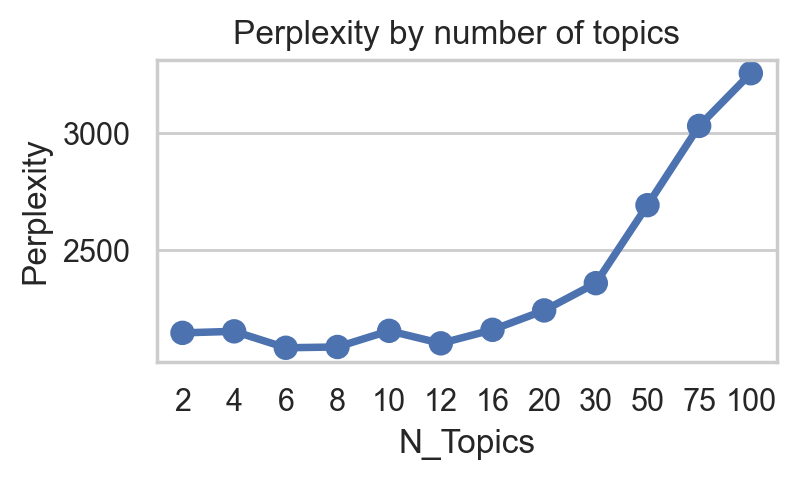

In [19]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Perplexity by number of topics");
sns.pointplot(x="N_Topics",
              y="Perplexity",
              data=lda_results);

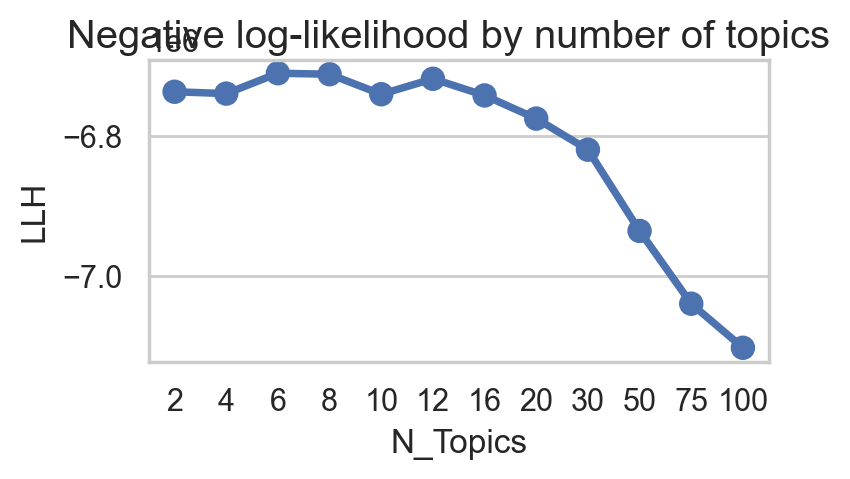

In [20]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Negative log-likelihood by number of topics");
sns.pointplot(x="N_Topics",
              y="LLH",
              data=lda_results);

## 3. Fit optimal model

In [21]:
## Final model
LDA = LatentDirichletAllocation(n_components=6,random_state=42)
LDA.fit(X_train_tfidf)

LatentDirichletAllocation(n_components=6, random_state=42)

In [22]:
## Number of components (=topics)
n_components = len(LDA.components_)
print("Number of components: ", n_components)

Number of components:  6


In [23]:
# print n top words per component
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[index] for index in (-topic).argsort()[:15]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['update', 'playing', 'phone', 'play', 'music', 'work', 'fix', 'stop', 'time', 'last', 'bar', 'screen', 'working', 'number', 'even']


THE TOP 15 WORDS FOR TOPIC #1
['music', 'great', 'good', 'easy', 'use', 'listen', 'best', 'songs', 'number', 'really', 'quality', 'premium', 'free', 'easy use', 'listening']


THE TOP 15 WORDS FOR TOPIC #2
['face', 'smiling', 'fix', 'internet', 'please', 'connection', 'every', 'problem', 'smiling face', 'song', 'please fix', 'face smiling', 'internet connection', 'eyes', 'lyrics']


THE TOP 15 WORDS FOR TOPIC #3
['ads', 'number', 'ad', 'song', 'songs', 'minutes', 'every', 'skip', 'number minutes', 'number songs', 'get', 'number ads', 'play', 'good', 'playing']


THE TOP 15 WORDS FOR TOPIC #4
['song', 'songs', 'play', 'best', 'want', 'playlist', 'music', 'listen', 'best music', 'shuffle', 'ever', 'plays', 'favorite', 'song want', 'hear']


THE TOP 15 WORDS FOR TOPIC #5
['premium', 'account', 'songs', 'log', 'would', 'even', 

In [24]:
## Let's give a descriptive name to the topics
lda_topics = ['phone_update_issue', 'spotify_is_awesome', 'internet_connection_issue', 'too_many_ads','playlists_and_songs', 'premium_account']

In [25]:
# turn this into a handy df
def get_model_topics(model, vectorizer, topics, n_top_words=10):    
    word_dict = {}    
    feature_names = vectorizer.get_feature_names()    
    for topic_idx, topic in enumerate(model.components_):        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]        
        top_features = [feature_names[i] for i in top_features_ind]        
        word_dict[topics[topic_idx]] = top_features
    return pd.DataFrame(word_dict)

In [26]:
get_model_topics(LDA, count_vectorizer, lda_topics)

,phone_update_issue,spotify_is_awesome,internet_connection_issue,too_many_ads,playlists_and_songs,premium_account
0,update,music,face,ads,song,premium
1,playing,great,smiling,number,songs,account
2,phone,good,fix,ad,play,songs
3,play,easy,internet,song,best,log
4,music,use,please,songs,want,would
5,work,listen,connection,minutes,playlist,even
6,fix,best,every,every,music,lyrics
7,stop,songs,problem,skip,listen,listen
8,time,number,smiling face,number minutes,best music,number
9,last,really,song,number songs,shuffle,get


## 4. Transform training data and assign topics

In [27]:
topic_results = LDA.transform(X_train_tfidf)
topic_results

array([[0.03051587, 0.03041899, 0.46156897, 0.0300627 , 0.417006  ,
        0.03042746],
       [0.03818714, 0.03770315, 0.03752222, 0.0373859 , 0.03789031,
        0.81131128],
       [0.02538715, 0.02598572, 0.02522632, 0.02528601, 0.02523118,
        0.87288362],
       ...,
       [0.03558099, 0.28008173, 0.03535758, 0.03531954, 0.03510628,
        0.57855389],
       [0.03229209, 0.83812685, 0.03217406, 0.03227717, 0.03272834,
        0.03240148],
       [0.05077349, 0.74552369, 0.05073228, 0.05080867, 0.05136282,
        0.05079904]])

In [28]:
# Split original data
data_train, _ = train_test_split(data, test_size=0.25, random_state=42)

In [29]:
pd.set_option('display.max_colwidth', 150)
data_train['Topic_number'] = topic_results.argmax(axis=1)
data_train[["Review", "Topic_number"]].head(10)

,Review,Topic_number
29893,great app best music platform but the group session feature needs work still they should add controll feature that let us someone be host of the ...,2
29959,spotifys best feature is the notifications for new releases by artists you follow but that feature has not been working for months after several u...,5
54863,would have gave number stars if spotify completely supported joe rogans freedom of expression and did not delete those number episodes am not fa...,5
54056,have to uninstall and reinstall multiple times to receive any new music podcast etc very buggy and have android lol,0
24842,good quantity of music and quality,1
2890,my experience with spotify is great love this platform thanks spotify team,1
9323,great to be able to create own playlist from number of choices,1
34086,there is one request for spotify please add recently added songs,4
38814,highly suggest not getting this have tried number months now to cancel my subscription it says its canceled yet they keep taking funds from me tr...,5
60771,really liked spotify at first but then it got updated or something and now it has gotten very annoying cannot enter my playlists to pick songs th...,5


In [30]:
# log-likelihood (measure of how plausible model parameters are given the data); lower is better 
# (it is actually NEGATIVE LLH; as every metric in sklearn is implemented so that lower is better)
print(LDA.score(X_train_counts))
# Perplexity (a measure of model's "surprise" at the data); lower is better
print(LDA.perplexity(X_train_counts))

-6709929.53515921
2083.257850658416


In [31]:
def assign_topic_name(topic_number):
    if topic_number == 0:
        return lda_topics[0]
    if topic_number == 1:
        return lda_topics[1]
    if topic_number == 2:
        return lda_topics[2]
    if topic_number == 3:
        return lda_topics[3]
    if topic_number == 4:
        return lda_topics[4]
    if topic_number == 5:
        return lda_topics[5]


data_train["Topic_name"] = data_train["Topic_number"].apply(assign_topic_name)

In [32]:
data_train[["Review", "Topic_name"]].sample(10)

,Review,Topic_name
1391,cannot play an individual song cannot choose specific playlist will not play songs in order and cannot listen offline or in between apps,playlists_and_songs
8265,struggle to connect with amazon echo auto,phone_update_issue
52234,awful app podcasts constantly stop you cannot see what you are listening to either very disappointing,phone_update_issue
209,way too many ads and it is always the same annoying number ffs,too_many_ads
22874,love it it is everything you wa to listen to muzic great appliation nothing this time to complain about may be next time,phone_update_issue
39787,this is great app but sometimes the ad will come in between the song but it is gerat app,too_many_ads
33598,relentless bluetooth popup,phone_update_issue
55940,there are too many adds pls reduce the amount of adds in normal subscription also,spotify_is_awesome
3970,love spotify premium it is affordable can listen from all my devices and get showtime as bonus,spotify_is_awesome
19311,music musical notes thought that would never heard again and music have never heard some of the best music listen to it all the time,playlists_and_songs


In [33]:
topic_f = pd.DataFrame(data_train["Topic_name"].value_counts()).reset_index()
topic_f.columns = ["Topic_name", "Count"]
topic_f

,Topic_name,Count
0,spotify_is_awesome,14246
1,phone_update_issue,10862
2,premium_account,7636
3,playlists_and_songs,6809
4,too_many_ads,3775
5,internet_connection_issue,2681


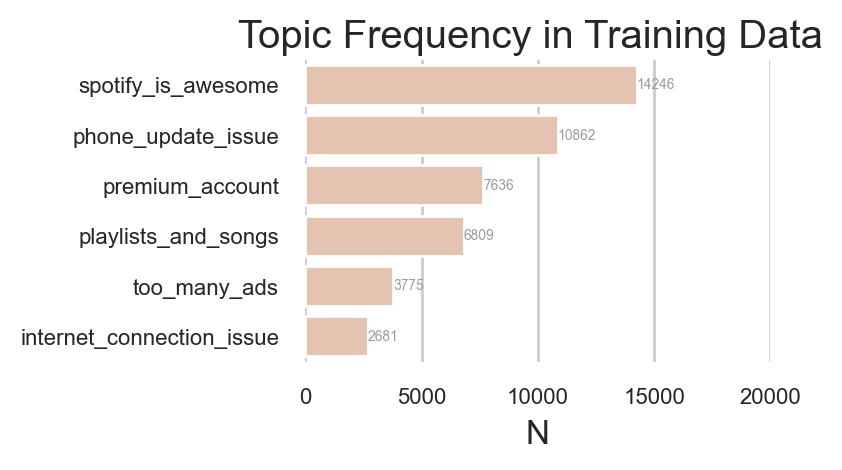

In [34]:
## Plot
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(3,2),dpi=200)

sns.set_color_codes("pastel")
sns.barplot(x="Count", 
            y="Topic_name", 
            data=topic_f,
            color = "#EDC2A7")

ax.set(xlim=(0, 20000), ylabel="",
       xlabel="N")
ax.bar_label(ax.containers[0], size=5, label_type="edge", padding=0, color="#999DA0")
plt.suptitle("Topic Frequency in Training Data")

ax.tick_params(labelsize=8)

sns.despine(left=True, bottom=True)

## 5. Transform entire dataset and plot topics over time

In [35]:
## define pipeline to predict a topic from a single input
def predict_topic(text):
    text_clean = clean_text(text)
    tokens = tokenizer.tokenize(text_clean)
    tokens_clean = [word for word in tokens if word not in (our_stopwords)]
    counts = count_vectorizer.transform([tokens_clean])
    tfids = tfidf_vectorizer.transform(counts)
    topics = LDA.transform(tfids)
    topic = topics.argmax(axis=1).flat[0]
    topic_name = lda_topics[topic]
    return topic_name


In [36]:
predict_topic("I downloaded this app yesterday great playlists")

'spotify_is_awesome'

In [37]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
ts_data = spotify.copy()
ts_data = ts_data.drop_duplicates(subset="Review")  # Drop dupes in Reviews
ts_data.drop(["Total_thumbsup",
             "Reply"], axis=1, inplace=True)
ts_data["Length"] = ts_data["Review"].str.split(" ").str.len()
ts_data = ts_data[ts_data.Length < 150]
ts_data.drop(["Length"], axis=1, inplace=True)
ts_data["Time_submitted"] = pd.to_datetime(ts_data["Time_submitted"])
ts_data["Topic"] = ts_data["Review"].apply(predict_topic)

In [38]:
ts_data.sample(10)

,Time_submitted,Review,Rating,Topic
36104,2022-04-14 04:28:07,"I have been paying for spotify for years and can't live without it, but recently: There's a bug the past week or so where the play bar doesnt appe...",1,phone_update_issue
16963,2022-05-29 20:37:36,Too many ads!!,4,too_many_ads
4060,2022-06-30 15:47:33,Overall the app is very good but we cant downlaod the song without premium if you remove thing your rating got 4.8,3,premium_account
29504,2022-04-24 23:32:42,"Horible it use to be good, i cant even choose the song i want to listen to and they added stuff to MY playlist?? Theres a reason i didnt have thos...",1,playlists_and_songs
3106,2022-07-02 19:05:49,"It's nice when l don't want to watch TV I have a great selection of music oldies and modern to listen to, goes with my moods brilliant",5,spotify_is_awesome
23179,2022-05-11 17:21:43,Adds are too annoying now than they ever were,4,spotify_is_awesome
50239,2022-02-23 09:28:17,"Love spotify, have been using it for ages now pretty much since you guys came out. Only issue I have is it is really hard/inconvenient to remove s...",4,phone_update_issue
43540,2022-03-20 17:13:30,Perfect! Free with No ads. Build your own playlist. They have pre made playlists based off your preferences. I absolutely love Spotify and I'm not...,5,spotify_is_awesome
17241,2022-05-29 05:50:48,Superb music selection~Fully enjoy all my stations,4,spotify_is_awesome
36843,2022-04-13 12:17:21,Has been buggy for me lately. Sometimes songs will randomly pause then play like 3 seconds later. Also sometimes when I open the app I can play mu...,2,phone_update_issue


In [40]:
ts_df = ts_data.resample('W', on='Time_submitted')['Topic'].value_counts()
ts_df = pd.DataFrame(ts_df)
ts_df.columns = ["Topic_count"]
ts_df = ts_df.reset_index()
ts_df.columns = ["Week", "Topic", "Topic_count"]

ts_df = ts_df.pivot_table('Topic_count', ['Week'], 'Topic').reset_index()
ts_df["Week"] = ts_df["Week"].astype(str)
ts_df.head(10)

Topic,Week,internet_connection_issue,phone_update_issue,playlists_and_songs,premium_account,spotify_is_awesome,too_many_ads
0,2022-01-02,4,15,8,13,31,17
1,2022-01-09,17,94,54,79,131,36
2,2022-01-16,30,193,114,141,241,70
3,2022-01-23,85,263,231,219,444,128
4,2022-01-30,92,315,293,605,731,193
5,2022-02-06,80,361,272,583,704,198
6,2022-02-13,98,370,261,394,622,168
7,2022-02-20,97,373,292,296,610,151
8,2022-02-27,101,289,246,273,595,136
9,2022-03-06,111,329,218,240,532,99


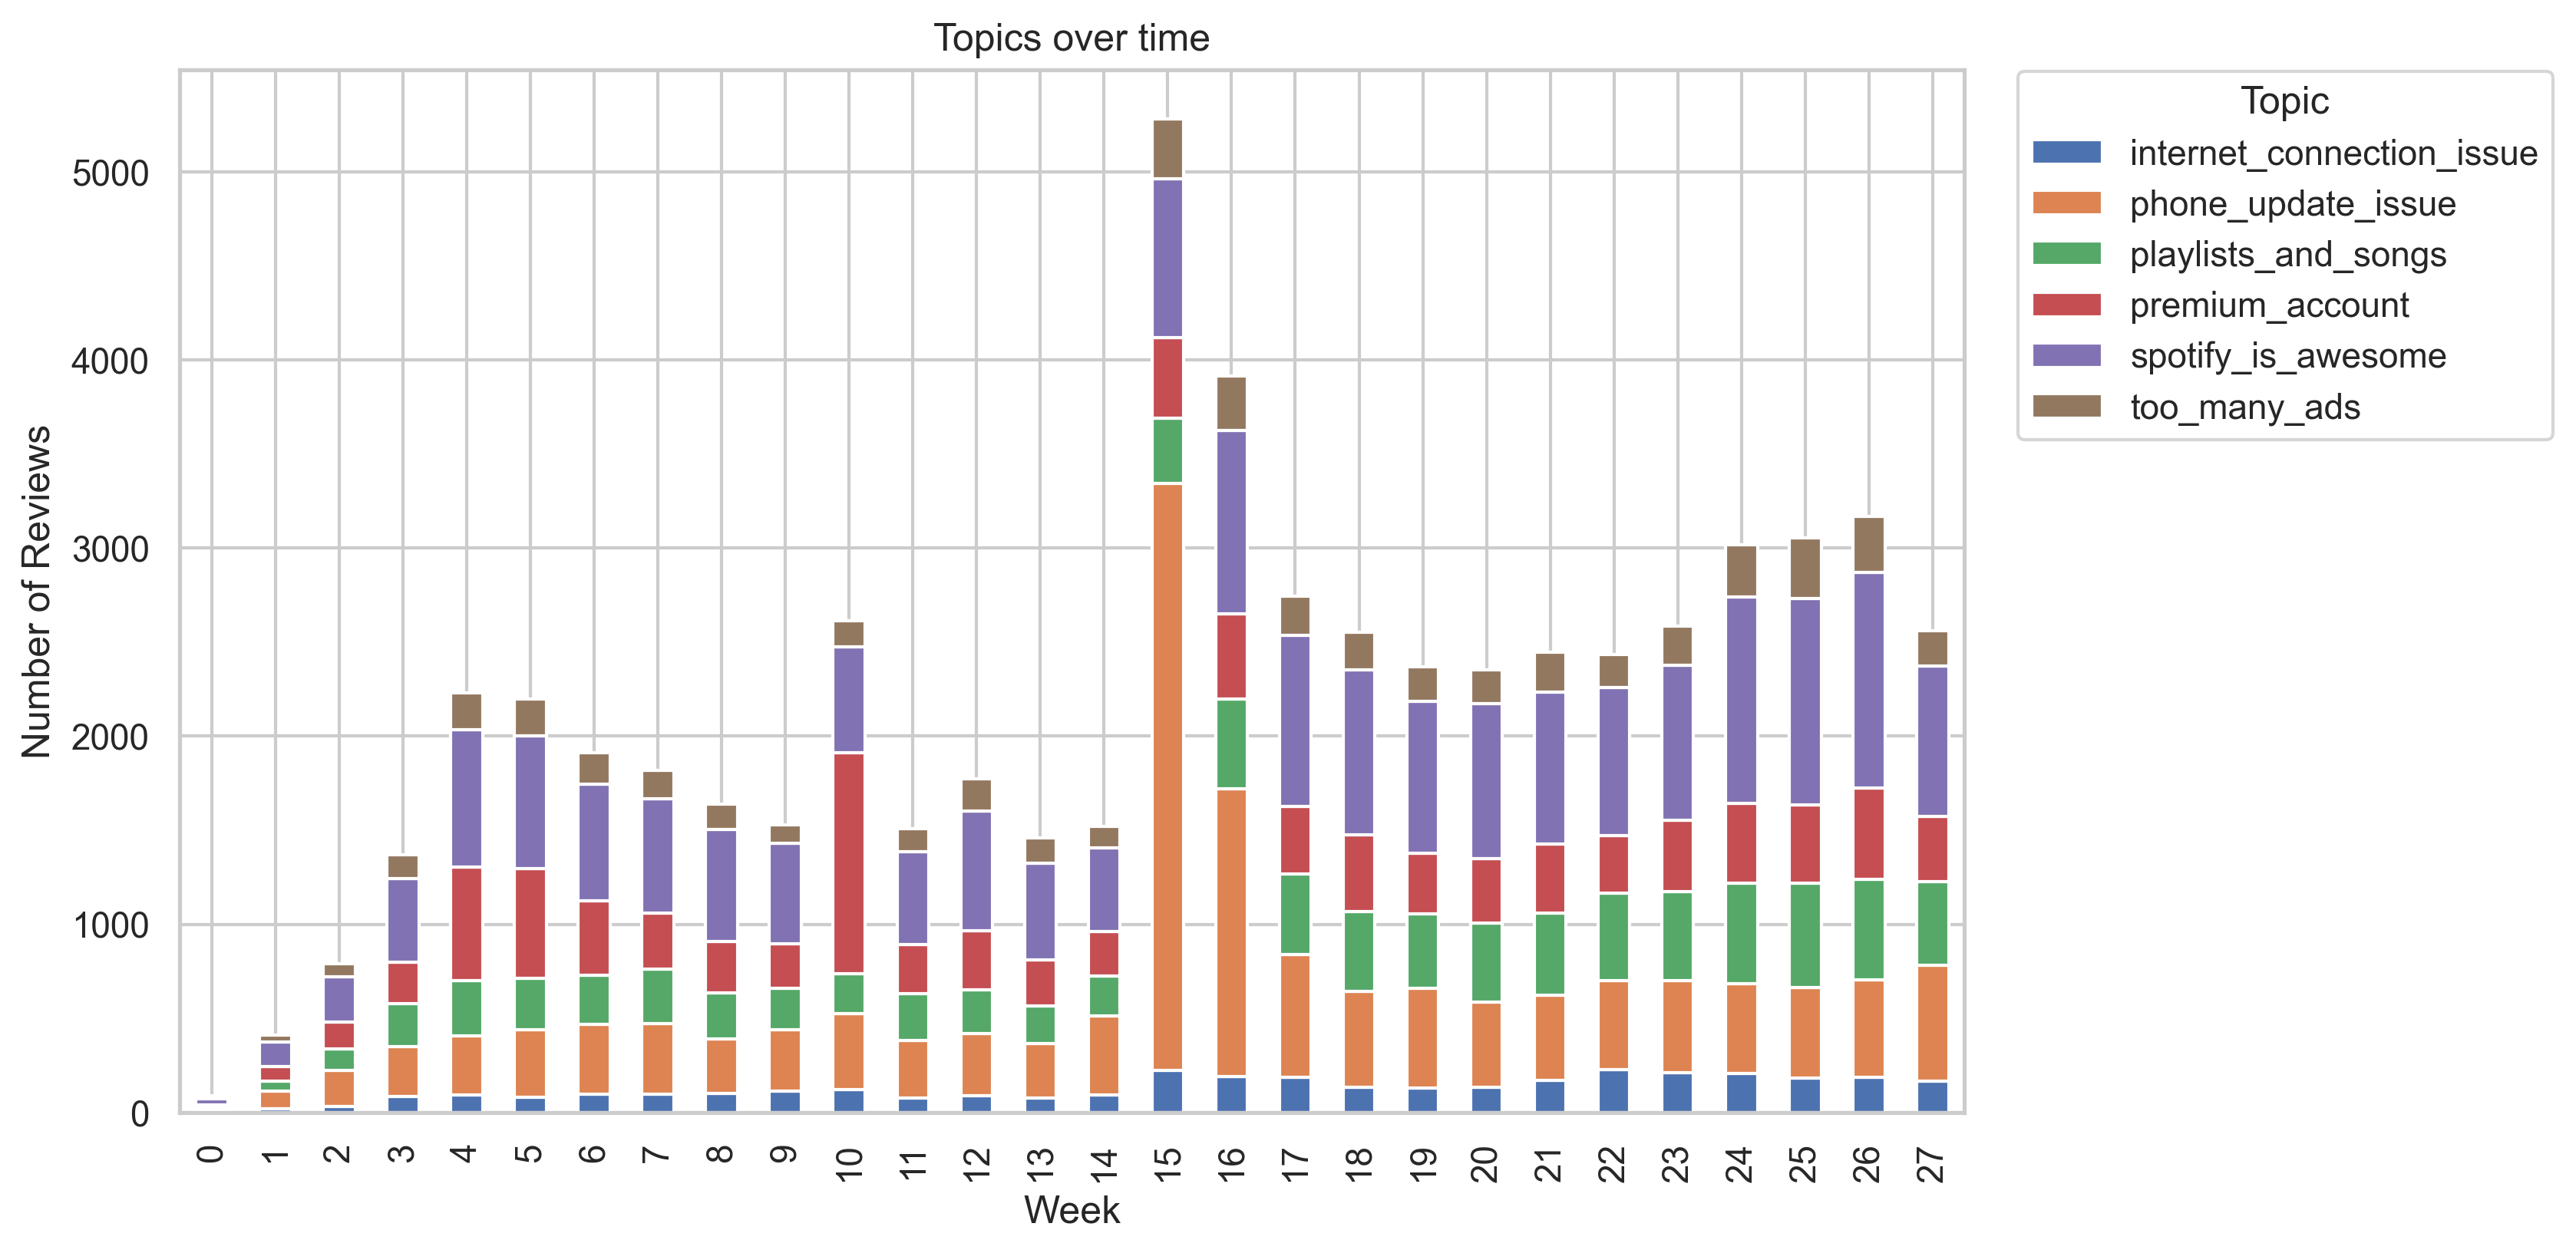

In [58]:
# plot the pivoted dataframe
plt.rcParams['figure.dpi'] = 300
ts_df.plot.bar(stacked=True, figsize=(10, 6), ylabel='Number of Reviews', xlabel='Week', title='Topics over time')
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1.015), loc='upper left')
plt.show()